<h1> Properly classify molecular smiles into: SMs, peptides, macrocycles, etc </h1>

<h3>Classification Categories</h3>
<I> Small molecules <br> Canonical peptidea <br> Noncanonical peptides <br> Cyclic peptides (lariat or circular) <br> Natural products <br> Glycans <br> RIPS  </I>

<br><br><br>

In [1]:
import sys, csv
import numpy as np 
import pandas as pd
import seaborn as sns
print(sys.executable)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sqlite3
import os 
from pathlib import Path
from tqdm.notebook import tqdm
from tqdm import tqdm
from mol_utils import MolecularClassifier
from rdkit import Chem
import pyarrow
import fastparquet
import joblib 

from mol_utils import classify_smiles

/fsx/alex/MolecularTypeClassifier-1/.pixi/envs/default/bin/python


In [2]:
import warnings
warnings.filterwarnings('ignore')


<br><br>

---------------------------------- Important Functions --------------------------------------------------------

In [3]:
#Extract individual features from each entry in df["canonical_smiles"]

classifier = MolecularClassifier()

def _mol_from_smiles(smiles: str):
    """Safe RDKit SMILES → Mol, handling bad/missing inputs."""
    if not isinstance(smiles, str) or not smiles.strip():
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # last-ditch attempt without sanitize; then sanitize manually
        try:
            mol = Chem.MolFromSmiles(smiles, sanitize=False)
            if mol is not None:
                Chem.SanitizeMol(mol)
        except Exception:
            return None
    return mol

def _features_for_smiles(smiles: str):
    """
    Return a dict of features for one SMILES.
    If parsing or featurization fails, return an empty dict so merge still works.
    """
    mol = _mol_from_smiles(smiles)
    if mol is None:
        return {}
    try:
        feats = classifier.extract_features(mol)
        # Normalize to dict for clean column creation
        if isinstance(feats, dict):
            return feats
        if isinstance(feats, pd.Series):
            return feats.to_dict()
        if isinstance(feats, (list, tuple)):
            return {f"feat_{i}": v for i, v in enumerate(feats)}
        # Fallback single value
        return {"feature": feats}
    except Exception:
        return {}


"""
    Function: Extract molecular features from input SMILES.

    Parameters
    ----------
    input_df(ex: df_MCRs) : pd.DataFrame 
        Input dataframe containing a SMILES column.
    smiles_col : str, default "canonical_smiles"
        Name of the column in df_MCRs that holds SMILES strings.
    prefix : str | None, default None
        Optional prefix to add to the generated feature columns (e.g., "feat_").
    show_progress : bool, default True
        Whether to display a tqdm progress bar while featurizing unique SMILES.
    verbose : bool, default True
        Whether to print a short summary and show head().

    Returns
    -------
    dataframe(ex: df_enriched) : pd.DataFrame
        The input dataframe concatenated with the extracted feature columns.
    features_df : pd.DataFrame
        The standalone features dataframe (one row per input row).
    """

def enrich_mcrs_with_features(
    input_df: pd.DataFrame,
    smiles_col: str = "canonical_smiles",
    prefix: str | None = None,
    show_progress: bool = True,
    verbose: bool = True,
):
    
    from tqdm.auto import tqdm as _tqdm  # local import to avoid hard dependency if not needed

    if smiles_col not in input_df.columns:
        raise KeyError(f"Column '{smiles_col}' not found in input_df.")

    # --- Speed-up: cache features for unique SMILES so duplicates aren’t recomputed ---
    unique_smiles = (
        input_df[smiles_col]
        .dropna()
        .astype(str)
        .unique()
    )

    _progress = _tqdm if show_progress else (lambda x, **k: x)
    feat_cache: dict[str, dict] = {}

    for s in _progress(unique_smiles, desc="Featurizing unique SMILES", ncols=80):
        feat_cache[s] = _features_for_smiles(s)

    # Map cached dicts back to each row, then expand dicts into columns
    features_list = [
        feat_cache.get(str(s), {}) if pd.notna(s) else {}
        for s in input_df[smiles_col]
    ]
    features_df = pd.DataFrame(features_list)

    # Optional: add a prefix to avoid any name collisions with existing columns
    if prefix:
        features_df = features_df.add_prefix(prefix)

    # Final enriched dataframe
    df_enriched = pd.concat(
        [input_df.reset_index(drop=True), features_df.reset_index(drop=True)],
        axis=1
    )

    if verbose:
        print(f"✅ Added {features_df.shape[1]} feature columns to {len(df_enriched)} rows.")
        try:
            display(df_enriched.head())
        except NameError:
            # display() may not exist outside notebooks; safe to skip
            pass

    return df_enriched, features_df





#Format the features extracted -> After you extract features, restructure the output into a dataframe (one feature per column)
import re
import ast

def parse_molecular_feature_string(feature_str: str) -> pd.DataFrame:
    """
    Parse a string like:
      MolecularFeatures(molecular_weight=1023.636..., ..., pattern_counts={'AA_PHENYLALANINE': 1, ...})
    into a one-row DataFrame with columns = feature names, values = parsed values.
    """
    if not isinstance(feature_str, str) or not feature_str.strip():
        raise ValueError("Input must be a non-empty string")

    s = feature_str.strip()

    # Remove wrapper
    if s.startswith("MolecularFeatures(") and s.endswith(")"):
        s = s[len("MolecularFeatures("):-1]

    # Extract pattern_counts first
    pattern_dict = {}
    m = re.search(r"pattern_counts\s*=\s*(\{.*\})", s)
    if m:
        pattern_text = m.group(1)
        s = s[:m.start()].rstrip().rstrip(",").rstrip()
        try:
            pattern_dict = ast.literal_eval(pattern_text)
        except Exception:
            pattern_dict = {}

    # Now split the remaining "k=v" pairs
    features = {}
    for kv in re.split(r"\s*,\s*", s):
        if "=" not in kv:
            continue
        k, v = kv.split("=", 1)
        k = k.strip()
        v = v.strip()
        try:
            # Try to coerce to float or int
            if re.fullmatch(r"[-+]?(?:\d+\.\d*|\d*\.\d+)(?:[eE][-+]?\d+)?", v):
                v = float(v)
            elif re.fullmatch(r"[-+]?\d+", v):
                v = int(v)
        except Exception:
            pass
        features[k] = v

    # Add pattern_counts entries as separate columns
    for pk, pv in pattern_dict.items():
        features[f"pattern_{pk}"] = pv

    # Convert to DataFrame
    df = pd.DataFrame([features])
    return df


<br>
----------------------------------------------------------------------------------------------------------------------
<br><br>

<br>

## I. Extract molecular features

In [ ]:
#Import positive controls
chunks = []
for chunk in pd.read_csv("Pos.ctrl_Molecules_merged.csv", chunksize=50000):
    chunks.append(chunk)
positive_ctrl_molecules = pd.concat(chunks, ignore_index=True)
len(positive_ctrl_molecules)
positive_ctrl_molecules.head(5)

,Class,SMILES
0,sm,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...
1,sm,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...
2,sm,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...
3,sm,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...
4,sm,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...


In [24]:
#Extract features from molecules
df_Pos_ctrl_enriched, Pos_ctrl_features_df = enrich_mcrs_with_features(
    positive_ctrl_molecules,
    smiles_col="SMILES",
    show_progress=True,
    verbose=True
)


Featurizing unique SMILES:   0%|                     | 0/216982 [00:00<?, ?it/s]

[02:11:48] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[02:11:48] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[02:11:48] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\\C=CC(=N2)\\C(=C2/N\\C(\\C=C2)=C(/C2=N/C(/C=C2)=C(\\C2=CC=C\\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\\C1=CC=C(C=C1)S(O)(O)[O-]
[02:11:48] SMILES Parse Error: check for mistakes around position 90:
[02:11:48] /C=C2)=C(\\C2=CC=C\\-1N2)C1=CC=C(C=C1)S(O
[02:11:48] ~~~~~~~~~~~~~~~~~~~~^
[02:11:48] SMILES Parse Error: extra open parentheses while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\\C=CC(=N2)\\C(=C2/N\\C(\\C=C2)=C(/C2=N/C(/C=C2)=C(\\C2=CC=C\\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\\C1=CC=C(C=C1)S(O)(O)[O-]
[02:11:48] SMILES Parse Error: check for mistakes around position 42:
[02:11:48] C-1=C2\\C=CC(=N2)\\C(=C2/N\\C(\\C=C2)=C(/
[02:11:48] ~~~~~~~~~~~~~~~~~~~~^
[02:11:48] SMILES Parse Error: extra open parentheses while pa

✅ Added 1 feature columns to 239365 rows.


,Class,SMILES,feature
0,sm,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,"MolecularFeatures(molecular_weight=2180.317, h..."
1,sm,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,MolecularFeatures(molecular_weight=1269.433000...
2,sm,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,MolecularFeatures(molecular_weight=1811.253000...
3,sm,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,MolecularFeatures(molecular_weight=1069.237999...
4,sm,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,MolecularFeatures(molecular_weight=1431.064000...


In [25]:
#Clean up features output - optimized version
def _parse_feature_to_dict(feature_str) -> dict:
    """Parse feature string to dict, returning empty dict on failure."""
    try:
        parsed_df = parse_molecular_feature_string(str(feature_str))
        return parsed_df.iloc[0].to_dict() if not parsed_df.empty else {}
    except Exception:
        return {}

# Use apply to parse all features at once (returns dicts, not DataFrames)
parsed_dicts = [
    _parse_feature_to_dict(feature_str)
    for feature_str in tqdm(df_Pos_ctrl_enriched["feature"], desc="Parsing features", ncols=80)
]

# Create single DataFrame from list of dicts (much faster than concatenating many small DataFrames)
parsed_features_df = pd.DataFrame(parsed_dicts)

# Merge with the original dataframe
out_df_Pos_ctrl_enriched = pd.concat(
    [df_Pos_ctrl_enriched.reset_index(drop=True), parsed_features_df.reset_index(drop=True)],
    axis=1
)

out_df_Pos_ctrl_enriched.head(5)

#out_df_Pos_ctrl_enriched.to_csv("PositiveCtrl_data_withFeatures", index=False);

Parsing features: 100%|███████████████| 239365/239365 [01:11<00:00, 3327.72it/s]


,Class,SMILES,feature,molecular_weight,heavy_atom_count,ring_count,largest_ring_size,percent_heavy_in_rings,rotatable_bonds,peptide_bond_count,...,pattern_GLYCOSIDIC_BOND,pattern_PYRANOSE,pattern_NUCLEOBASE_URACIL,pattern_GALACTOSE,pattern_GLUCOSE,pattern_MANNOSE,pattern_NUCLEOBASE_GUANINE,pattern_NUCLEOBASE_THYMINE,pattern_NUCLEOBASE_CYTOSINE,pattern_DEOXYRIBOSE
0,sm,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,"MolecularFeatures(molecular_weight=2180.317, h...",2180.317,155.0,6.0,6.0,21.290323,66.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sm,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,MolecularFeatures(molecular_weight=1269.433000...,1269.433,91.0,6.0,6.0,32.967033,31.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sm,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,MolecularFeatures(molecular_weight=1811.253000...,1811.253,131.0,8.0,6.0,27.480916,51.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sm,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,MolecularFeatures(molecular_weight=1069.237999...,1069.238,74.0,4.0,20.0,50.000000,19.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sm,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,MolecularFeatures(molecular_weight=1431.064000...,1431.064,102.0,6.0,6.0,32.352941,38.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#out_df_Pos_ctrl_enriched.to_csv("PositiveCtrl_data_withFeatures.csv");

<br><br>

## II. Build random forest

In [13]:
# === More libraries ===
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from typing import Tuple, Optional

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib

# Try imblearn for oversampling; otherwise use a simple fallback
try:
    from imblearn.over_sampling import RandomOverSampler as ImbRandomOverSampler
    _HAS_IMB = True
except Exception:
    _HAS_IMB = False

# === Helper Functions ===
def ensure_numeric_features(df: pd.DataFrame) -> pd.DataFrame:
    """Coerce non-numeric columns (except label) to numeric where possible; drop others and impute."""
    df_num = df.apply(pd.to_numeric, errors='coerce')
    df_num = df_num.dropna(axis=1, how='all')
    df_num = df_num.fillna(df_num.median(numeric_only=True))
    return df_num

def oversample_training(
    X: np.ndarray, y: np.ndarray, seed: int = 42
) -> Tuple[np.ndarray, np.ndarray]:
    """Oversample minority classes to the majority count."""
    if _HAS_IMB:
        ros = ImbRandomOverSampler(random_state=seed)
        X_res, y_res = ros.fit_resample(X, y)
        return X_res, y_res

    # Fallback: simple random replication up to the majority count
    rng = np.random.default_rng(seed)
    X_list, y_list = [], []
    counts = Counter(y)
    max_n = max(counts.values())
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        need = max_n - len(idx)
        if need > 0:
            add_idx = rng.choice(idx, size=need, replace=True)
            X_cls = np.vstack([X[idx], X[add_idx]])
            y_cls = np.concatenate([y[idx], y[add_idx]])
        else:
            X_cls = X[idx]
            y_cls = y[idx]
        X_list.append(X_cls)
        y_list.append(y_cls)
    X_res = np.vstack(X_list)
    y_res = np.concatenate(y_list)
    perm = rng.permutation(len(y_res))
    return X_res[perm], y_res[perm]


# === Module 1: Split Data + Output ===
def prepare_data_splits(
    M: pd.DataFrame,
    label_col: Optional[str] = None,
    test_size: float = 0.10,
    seed: int = 42,
    verbose: bool = True,
) -> dict:
    """
    Prepare and split data for training.
    
    Parameters
    ----------
    M : pd.DataFrame
        DataFrame with first column = known label (string-like), remaining columns = numeric features.
    label_col : Optional[str], default None
        Name of the label column. If None, uses first column.
    test_size : float, default 0.10
        Proportion of data to use for testing.
    seed : int, default 42
        Random seed for reproducibility.
    verbose : bool, default True
        Whether to print oversampling summary.
        
    Returns
    -------
    dict
        Dictionary containing:
        - 'X_train': Training features
        - 'X_test': Test features
        - 'y_train': Training labels (encoded)
        - 'y_test': Test labels (encoded)
        - 'X_train_oversampled': Oversampled training features
        - 'y_train_oversampled': Oversampled training labels (encoded)
        - 'X_all': All features
        - 'y_all': All labels (encoded)
        - 'label_encoder': Fitted LabelEncoder
        - 'idx_train': Training indices
        - 'idx_test': Test indices
    """
    # Parse label + features
    if label_col is None:
        label_col = M.columns[0]
    labels = M[label_col].astype(str).values
    X_df = M.drop(columns=[label_col])

    # Only numeric features; coerce/deduplicate
    X_df_num = ensure_numeric_features(X_df)
    mask_finite = np.isfinite(X_df_num.values).sum(axis=1) > 0
    X_df_num = X_df_num.loc[mask_finite]
    labels = labels[mask_finite]

    # Check for classes with < 2 members before encoding (can't use stratified split)
    unique_labels_str, counts = np.unique(labels, return_counts=True)
    classes_with_one_str = unique_labels_str[counts < 2]
    
    if len(classes_with_one_str) > 0:
        # Remove classes with only 1 member before encoding
        mask_keep = ~np.isin(labels, classes_with_one_str)
        X_df_num = X_df_num.loc[mask_keep]
        labels = labels[mask_keep]
        
        if verbose:
            print(f"\n⚠️  Warning: Removed {len(classes_with_one_str)} class(es) with only 1 member: {list(classes_with_one_str)}")
            print(f"   Continuing with {len(labels)} samples and {len(np.unique(labels))} classes.")
    
    # Encode labels (after removing single-member classes)
    le = LabelEncoder()
    y_all = le.fit_transform(labels)
    X_all = X_df_num.values.astype(np.float32)
    
    # 90/10 stratified split (only if all classes have >= 2 members)
    use_stratify = len(np.unique(y_all)) > 0 and np.min(np.bincount(y_all)) >= 2
    
    if use_stratify:
        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X_all, y_all, np.arange(len(y_all)),
            test_size=test_size, random_state=seed, stratify=y_all
        )
    else:
        # Use non-stratified split if stratification is not possible
        if verbose:
            print("⚠️  Warning: Using non-stratified split (some classes may have < 2 members).")
        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X_all, y_all, np.arange(len(y_all)),
            test_size=test_size, random_state=seed, stratify=None
        )

    # Oversample the training set
    X_tr_os, y_tr_os = oversample_training(X_train, y_train, seed=seed)

    # Print oversampling summary
    if verbose:
        counts_before = Counter(y_train)
        counts_after = Counter(y_tr_os)
        
        print("\n=== Oversampling Summary ===")
        print("Original training class distribution (90% split):")
        for lbl_idx in sorted(counts_before.keys()):
            print(f"  {le.inverse_transform([lbl_idx])[0]}: {counts_before[lbl_idx]} molecules")
        
        print("\nAfter oversampling (balanced classes):")
        for lbl_idx in sorted(counts_after.keys()):
            print(f"  {le.inverse_transform([lbl_idx])[0]}: {counts_after[lbl_idx]} molecules")

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_oversampled': X_tr_os,
        'y_train_oversampled': y_tr_os,
        'X_all': X_all,
        'y_all': y_all,
        'label_encoder': le,
        'idx_train': idx_train,
        'idx_test': idx_test,
    }


# === Module 2: Build, Train, Run Random Forest Model ===
def build_classifier(
    n_estimators: int = 400,
    max_depth: Optional[int] = None,
    min_samples_leaf: int = 1,
    n_jobs: int = 4,
    seed: int = 42,
) -> RandomForestClassifier:
    """Build RandomForest classifier with memory-safe default n_jobs."""
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=seed,
        n_jobs=n_jobs,
        class_weight=None,  # we oversample, so no class weights
    )


def train_random_forest_model(
    X_train: np.ndarray,
    y_train: np.ndarray,
    n_estimators: int = 400,
    max_depth: Optional[int] = None,
    min_samples_leaf: int = 1,
    n_jobs: int = 4,
    seed: int = 42,
    cv_folds: int = 5,
    evaluate_cv: bool = True,
) -> Tuple[RandomForestClassifier, Optional[np.ndarray]]:
    """
    Build and train a Random Forest model.
    
    Parameters
    ----------
    X_train : np.ndarray
        Training features.
    y_train : np.ndarray
        Training labels (encoded).
    n_estimators : int, default 400
        Number of trees in the forest.
    max_depth : Optional[int], default None
        Maximum depth of the tree.
    min_samples_leaf : int, default 1
        Minimum number of samples required to be at a leaf node.
    n_jobs : int, default 4
        Number of parallel jobs for training.
    seed : int, default 42
        Random seed for reproducibility.
    cv_folds : int, default 5
        Number of folds for cross-validation evaluation.
    evaluate_cv : bool, default True
        Whether to perform cross-validation evaluation.
        
    Returns
    -------
    Tuple[RandomForestClassifier, Optional[np.ndarray]]
        Trained classifier and cross-validation predictions (if evaluate_cv=True).
    """
    # Build classifier
    clf = build_classifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        n_jobs=n_jobs,
        seed=seed,
    )
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Optional: Cross-validation evaluation
    y_pred_cv = None
    if evaluate_cv:
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=seed)
        y_pred_cv = cross_val_predict(clf, X_train, y_train, cv=skf, n_jobs=min(n_jobs, 2))
    
    return clf, y_pred_cv


# === Module 3: Evaluation on Holdout Data & Print Output Stats ===
def evaluate_model(
    clf: RandomForestClassifier,
    X_test: np.ndarray,
    y_test: np.ndarray,
    label_encoder: LabelEncoder,
    X_train: Optional[np.ndarray] = None,
    y_train: Optional[np.ndarray] = None,
    y_pred_cv: Optional[np.ndarray] = None,
) -> Tuple[np.ndarray, np.ndarray, dict]:
    """
    Evaluate model on holdout data and print statistics.
    
    Parameters
    ----------
    clf : RandomForestClassifier
        Trained classifier.
    X_test : np.ndarray
        Test features.
    y_test : np.ndarray
        Test labels (encoded).
    label_encoder : LabelEncoder
        Fitted label encoder.
    X_train : Optional[np.ndarray], default None
        Training features (for CV evaluation if y_pred_cv is None).
    y_train : Optional[np.ndarray], default None
        Training labels (for CV evaluation if y_pred_cv is None).
    y_pred_cv : Optional[np.ndarray], default None
        Cross-validation predictions on training set.
        
    Returns
    -------
    Tuple[np.ndarray, np.ndarray, dict]
        (y_test_true, y_test_pred, evaluation_stats)
        evaluation_stats contains:
        - 'test_accuracy': Test set accuracy
        - 'test_report': Test set classification report (dict)
        - 'cv_accuracy': CV accuracy (if y_pred_cv provided)
        - 'cv_report': CV classification report (dict, if y_pred_cv provided)
        - 'confusion_matrix_test': Test set confusion matrix
        - 'confusion_matrix_test_norm': Normalized test set confusion matrix
        - 'confusion_matrix_cv': CV confusion matrix (if y_pred_cv provided)
    """
    # Evaluate on holdout
    y_test_pred = clf.predict(X_test)
    
    print("\n=== Holdout (10%) performance ===")
    print("Accuracy:", f"{accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, digits=3))
    
    # Cross-validation evaluation (if provided)
    if y_pred_cv is not None and X_train is not None and y_train is not None:
        print("\n=== Cross-validated (on training split) metrics ===")
        print("Accuracy:", f"{accuracy_score(y_train, y_pred_cv):.4f}")
        print(classification_report(y_train, y_pred_cv, target_names=label_encoder.classes_, digits=3))
    
    # Compare known vs predicted on holdout
    print("\n=== Holdout known vs predicted label comparison (counts) ===")
    comp = pd.DataFrame({
        "known": label_encoder.inverse_transform(y_test),
        "pred": label_encoder.inverse_transform(y_test_pred)
    })
    print(
        comp.value_counts()
            .rename("count")
            .reset_index()
            .sort_values("count", ascending=False)
            .to_string(index=False)
    )
    
    # Collect evaluation stats and confusion matrices
    labels_full = np.arange(len(label_encoder.classes_))
    cm_test = confusion_matrix(y_test, y_test_pred, labels=labels_full)
    cm_test_norm = confusion_matrix(y_test, y_test_pred, labels=labels_full, normalize='true')
    
    stats = {
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'test_report': classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, digits=3, output_dict=True),
        'confusion_matrix_test': cm_test,
        'confusion_matrix_test_norm': cm_test_norm,
        'label_encoder': label_encoder,
    }
    
    if y_pred_cv is not None and y_train is not None:
        cm_cv = confusion_matrix(y_train, y_pred_cv, labels=labels_full)
        stats['cv_accuracy'] = accuracy_score(y_train, y_pred_cv)
        stats['cv_report'] = classification_report(y_train, y_pred_cv, target_names=label_encoder.classes_, digits=3, output_dict=True)
        stats['confusion_matrix_cv'] = cm_cv
    
    return y_test, y_test_pred, stats


# === Module 4: Plot Results (Separated from computation) ===
def plot_confusion_matrix_test(
    evaluation_stats: dict,
    show_plot: bool = True,
) -> plt.Figure:
    """
    Plot test set confusion matrix.
    
    Parameters
    ----------
    evaluation_stats : dict
        Dictionary containing confusion matrices and label encoder from evaluate_model().
    show_plot : bool, default True
        Whether to display plot immediately. If False, returns figure without showing.
        
    Returns
    -------
    plt.Figure
        Matplotlib figure object.
    """
    label_encoder = evaluation_stats['label_encoder']
    cm_test = evaluation_stats['confusion_matrix_test']
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
    disp.plot(ax=ax, xticks_rotation=45, values_format="d")
    ax.set_title("Confusion Matrix (Holdout)")
    plt.tight_layout()
    if show_plot:
        plt.show()
    return fig


def plot_confusion_matrix_test_norm(
    evaluation_stats: dict,
    show_plot: bool = True,
) -> plt.Figure:
    """
    Plot normalized test set confusion matrix.
    
    Parameters
    ----------
    evaluation_stats : dict
        Dictionary containing confusion matrices and label encoder from evaluate_model().
    show_plot : bool, default True
        Whether to display plot immediately. If False, returns figure without showing.
        
    Returns
    -------
    plt.Figure
        Matplotlib figure object.
    """
    label_encoder = evaluation_stats['label_encoder']
    cm_test_norm = evaluation_stats['confusion_matrix_test_norm']
    fig, ax = plt.subplots(figsize=(10, 8))
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_test_norm, display_labels=label_encoder.classes_)
    disp_norm.plot(ax=ax, xticks_rotation=45, values_format=".2f")
    ax.set_title("Holdout Confusion Matrix (Normalized)")
    plt.tight_layout()
    if show_plot:
        plt.show()
    return fig


def plot_confusion_matrix_cv(
    evaluation_stats: dict,
    show_plot: bool = True,
) -> Optional[plt.Figure]:
    """
    Plot cross-validation confusion matrix.
    
    Parameters
    ----------
    evaluation_stats : dict
        Dictionary containing confusion matrices and label encoder from evaluate_model().
    show_plot : bool, default True
        Whether to display plot immediately. If False, returns figure without showing.
        
    Returns
    -------
    Optional[plt.Figure]
        Matplotlib figure object, or None if CV confusion matrix is not available.
    """
    if 'confusion_matrix_cv' not in evaluation_stats:
        return None
    
    label_encoder = evaluation_stats['label_encoder']
    cm_cv = evaluation_stats['confusion_matrix_cv']
    fig, ax = plt.subplots(figsize=(10, 8))
    disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=label_encoder.classes_)
    disp_cv.plot(ax=ax, xticks_rotation=45, values_format="d")
    ax.set_title("Confusion Matrix (CV on training split)")
    plt.tight_layout()
    if show_plot:
        plt.show()
    return fig


def _compute_embedding(
    X_all: np.ndarray,
    method: str = "umap",
) -> Tuple[np.ndarray, str]:
    """
    Compute 2D embedding for visualization.
    
    Parameters
    ----------
    X_all : np.ndarray
        All features.
    method : str, default "umap"
        Dimensionality reduction method ("pca" or "umap").
        
    Returns
    -------
    Tuple[np.ndarray, str]
        Embedding array and subtitle string.
    """
    if method == "pca":
        reducer = PCA(n_components=2, random_state=42)
        emb = reducer.fit_transform(X_all)
        subtitle = "PCA (2D)"
    else:
        try:
            import umap
            reducer = umap.UMAP(n_components=2, random_state=42)
            emb = reducer.fit_transform(X_all)
            subtitle = "UMAP (2D)"
        except Exception:
            print("UMAP not available; falling back to PCA.")
            reducer = PCA(n_components=2, random_state=42)
            emb = reducer.fit_transform(X_all)
            subtitle = "PCA (2D)"
    return emb, subtitle


def plot_projection_known_labels(
    X_all: np.ndarray,
    y_all: np.ndarray,
    label_encoder: LabelEncoder,
    method: str = "umap",
    title: str = "Molecule feature space",
    show_plot: bool = True,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
) -> plt.Figure:
    """
    Plot 2D projection colored by known labels.
    
    Parameters
    ----------
    X_all : np.ndarray
        All features.
    y_all : np.ndarray
        All labels (encoded).
    label_encoder : LabelEncoder
        Fitted label encoder.
    method : str, default "umap"
        Dimensionality reduction method ("pca" or "umap").
    title : str, default "Molecule feature space"
        Title for the plot.
    show_plot : bool, default True
        Whether to display plot immediately. If False, returns figure without showing.
    xlim : Optional[Tuple[float, float]], default None
        X-axis limits as (xmin, xmax). If None, uses automatic limits.
    ylim : Optional[Tuple[float, float]], default None
        Y-axis limits as (ymin, ymax). If None, uses automatic limits.
        
    Returns
    -------
    plt.Figure
        Matplotlib figure object.
    """
    emb, subtitle = _compute_embedding(X_all, method)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    uniq = np.unique(y_all)
    for u in uniq:
        mask = y_all == u
        ax.scatter(emb[mask, 0], emb[mask, 1], s=18, alpha=0.8, label=label_encoder.inverse_transform([u])[0])
    ax.legend(markerscale=1.5, fontsize=8, title="Known")
    ax.set_title(f"{title}: {subtitle} colored by known labels")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.tight_layout()
    if show_plot:
        plt.show()
    return fig


def plot_projection_predicted_labels(
    X_all: np.ndarray,
    y_pred_all: np.ndarray,
    label_encoder: LabelEncoder,
    method: str = "umap",
    title: str = "Molecule feature space",
    show_plot: bool = True,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    max_labels: int = 1500,
) -> plt.Figure:
    """
    Plot 2D projection with predicted labels as text overlay.
    
    Parameters
    ----------
    X_all : np.ndarray
        All features.
    y_pred_all : np.ndarray
        Predicted labels for all samples (encoded).
    label_encoder : LabelEncoder
        Fitted label encoder.
    method : str, default "umap"
        Dimensionality reduction method ("pca" or "umap").
    title : str, default "Molecule feature space"
        Title for the plot.
    show_plot : bool, default True
        Whether to display plot immediately. If False, returns figure without showing.
    xlim : Optional[Tuple[float, float]], default None
        X-axis limits as (xmin, xmax). If None, uses automatic limits.
    ylim : Optional[Tuple[float, float]], default None
        Y-axis limits as (ymin, ymax). If None, uses automatic limits.
    max_labels : int, default 1500
        Maximum number of labels to display. If dataset is larger, randomly samples.
        
    Returns
    -------
    plt.Figure
        Matplotlib figure object.
    """
    emb, subtitle = _compute_embedding(X_all, method)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(emb[:, 0], emb[:, 1], s=8, alpha=0.25)
    n = emb.shape[0]
    idxs = np.arange(n)
    if n > max_labels:
        rng = np.random.default_rng(42)
        idxs = rng.choice(idxs, size=max_labels, replace=False)
    for i in idxs:
        lbl = label_encoder.inverse_transform([y_pred_all[i]])[0]
        ax.text(emb[i, 0], emb[i, 1], lbl, fontsize=6, alpha=0.8)
    ax.set_title(f"{title}: {subtitle} with predicted labels text overlay")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.tight_layout()
    if show_plot:
        plt.show()
    return fig





def plot_all_results(
    results: dict,
    method: str = "umap",
    show_plots: bool = True,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
) -> dict:
    """
    Generate all plots from pipeline results.
    
    This is a convenience function that calls individual plot functions.
    For more control, call individual plot functions directly.
    
    Parameters
    ----------
    results : dict
        Results dictionary from run_pipeline_from_matrix() containing:
        - 'evaluation_stats': Evaluation statistics with confusion matrices
        - 'data_splits': Data splits dictionary with X_all, y_all, etc.
        - 'y_pred_all': Predictions for all samples (optional)
    method : str, default "umap"
        Dimensionality reduction method for visualization ("pca" or "umap").
    show_plots : bool, default True
        Whether to display plots immediately. If False, returns figures without showing.
    xlim : Optional[Tuple[float, float]], default None
        X-axis limits as (xmin, xmax). If None, uses automatic limits.
    ylim : Optional[Tuple[float, float]], default None
        Y-axis limits as (ymin, ymax). If None, uses automatic limits.
        
    Returns
    -------
    dict
        Dictionary containing:
        - 'confusion_matrix_test': Test confusion matrix figure
        - 'confusion_matrix_test_norm': Normalized test confusion matrix figure
        - 'confusion_matrix_cv': CV confusion matrix figure (if available)
        - 'projection_known': Projection colored by known labels figure
        - 'projection_predicted': Projection with predicted labels figure (if y_pred_all available)
    """
    plot_results = {}
    
    # Plot confusion matrices
    if 'evaluation_stats' in results:
        plot_results['confusion_matrix_test'] = plot_confusion_matrix_test(
            results['evaluation_stats'],
            show_plot=show_plots,
        )
        plot_results['confusion_matrix_test_norm'] = plot_confusion_matrix_test_norm(
            results['evaluation_stats'],
            show_plot=show_plots,
        )
        plot_results['confusion_matrix_cv'] = plot_confusion_matrix_cv(
            results['evaluation_stats'],
            show_plot=show_plots,
        )
    
    # Plot projections
    if 'data_splits' in results:
        data = results['data_splits']
        y_pred_all = results.get('y_pred_all', None)
        
        plot_results['projection_known'] = plot_projection_known_labels(
            data['X_all'],
            data['y_all'],
            data['label_encoder'],
            method=method,
            title="Molecule feature space",
            show_plot=show_plots,
            xlim=xlim,
            ylim=ylim,
        )
        
        if y_pred_all is not None:
            plot_results['projection_predicted'] = plot_projection_predicted_labels(
                data['X_all'],
                y_pred_all,
                data['label_encoder'],
                method=method,
                title="Molecule feature space",
                show_plot=show_plots,
                xlim=xlim,
                ylim=ylim,
            )
    
    return plot_results


# === Convenience Function: Run Full Pipeline ===
def run_pipeline_from_matrix(
    M: pd.DataFrame,
    label_col: Optional[str] = None,
    seed: int = 42,
    n_jobs: int = 2,
    test_size: float = 0.10,
    n_estimators: int = 400,
    cv_folds: int = 5,
    plot_results: bool = False,
    plot_method: str = "umap",
) -> dict:
    """
    Run the complete pipeline from data preparation to evaluation.
    
    This is a convenience function that chains all modules together.
    Plotting is separated and can be done later using plot_all_results().
    
    Parameters
    ----------
    M : pd.DataFrame
        DataFrame with first column = known label (string-like), remaining columns = numeric features.
    label_col : Optional[str], default None
        Name of the label column. If None, uses first column.
    seed : int, default 42
        Random seed for reproducibility.
    n_jobs : int, default 2
        Number of parallel jobs for training and CV.
    test_size : float, default 0.10
        Proportion of data to use for testing.
    n_estimators : int, default 400
        Number of trees in the Random Forest.
    cv_folds : int, default 5
        Number of folds for cross-validation.
    plot_results : bool, default False
        Whether to generate plots immediately. If False, plots can be generated later.
    plot_method : str, default "umap"
        Dimensionality reduction method for visualization ("pca" or "umap").
        
    Returns
    -------
    dict
        Dictionary containing:
        - 'classifier': Trained RandomForestClassifier
        - 'label_encoder': Fitted LabelEncoder
        - 'evaluation_stats': Evaluation statistics with confusion matrices
        - 'data_splits': Data splits dictionary
        - 'y_pred_all': Predictions for all samples (for plotting)
        - 'y_test_true': True test labels
        - 'y_test_pred': Predicted test labels
        - 'y_pred_cv_train': CV predictions on training set
    """
    # 1. Prepare data splits
    data = prepare_data_splits(M, label_col=label_col, test_size=test_size, seed=seed, verbose=True)
    
    # 2. Train model on oversampled data (but don't evaluate CV on oversampled data)
    clf, _ = train_random_forest_model(
        data['X_train_oversampled'],
        data['y_train_oversampled'],
        n_estimators=n_estimators,
        n_jobs=n_jobs,
        seed=seed,
        cv_folds=cv_folds,
        evaluate_cv=False,  # We'll do CV on original training data for evaluation
    )
    
    # 3. Do CV on original training data for evaluation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=seed)
    y_pred_cv_train = cross_val_predict(clf, data['X_train'], data['y_train'], cv=skf, n_jobs=n_jobs)
    
    # 4. Evaluate model
    y_test_true, y_test_pred, stats = evaluate_model(
        clf,
        data['X_test'],
        data['y_test'],
        data['label_encoder'],
        X_train=data['X_train'],
        y_train=data['y_train'],
        y_pred_cv=y_pred_cv_train,
    )
    
    # 5. Predict labels for ALL points for visualization
    y_pred_all = np.empty_like(data['y_all'])
    y_pred_all[data['idx_train']] = y_pred_cv_train
    y_pred_all[data['idx_test']] = clf.predict(data['X_test'])
    
    # 6. Store results
    results = {
        'classifier': clf,
        'label_encoder': data['label_encoder'],
        'evaluation_stats': stats,
        'data_splits': data,
        'y_pred_all': y_pred_all,
        'y_test_true': y_test_true,
        'y_test_pred': y_test_pred,
        'y_pred_cv_train': y_pred_cv_train,
    }
    
    # 7. Plot results if requested
    if plot_results:
        plot_all_results(results, method=plot_method, show_plots=True)
    
    return results


In [14]:
# Read CSV.gz file with chunked reading
chunks = []
for chunk in pd.read_csv("PositiveCtrl_data_withFeatures.csv.gz", chunksize=50000):
    chunks.append(chunk)
out_df_Pos_ctrl_enriched = pd.concat(chunks, ignore_index=True)
out_df_Pos_ctrl_enriched.head(5)

,Unnamed: 0,Class,SMILES,feature,molecular_weight,heavy_atom_count,ring_count,largest_ring_size,percent_heavy_in_rings,rotatable_bonds,...,pattern_GLYCOSIDIC_BOND,pattern_PYRANOSE,pattern_NUCLEOBASE_URACIL,pattern_GALACTOSE,pattern_GLUCOSE,pattern_MANNOSE,pattern_NUCLEOBASE_GUANINE,pattern_NUCLEOBASE_THYMINE,pattern_NUCLEOBASE_CYTOSINE,pattern_DEOXYRIBOSE
0,0,sm,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,"MolecularFeatures(molecular_weight=2180.317, h...",2180.317,155.0,6.0,6.0,21.290323,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,sm,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,MolecularFeatures(molecular_weight=1269.433000...,1269.433,91.0,6.0,6.0,32.967033,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,sm,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,MolecularFeatures(molecular_weight=1811.253000...,1811.253,131.0,8.0,6.0,27.480916,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,sm,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,MolecularFeatures(molecular_weight=1069.237999...,1069.238,74.0,4.0,20.0,50.000000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,sm,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,MolecularFeatures(molecular_weight=1431.064000...,1431.064,102.0,6.0,6.0,32.352941,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Create training dataframe with "Class" as labels and all columns from "molecular_weight" onwards as features
# Find the index of "molecular_weight" column
molecular_weight_idx = out_df_Pos_ctrl_enriched.columns.get_loc("molecular_weight")

# Select Class column and all columns from molecular_weight onwards
feature_columns = out_df_Pos_ctrl_enriched.columns[molecular_weight_idx:].tolist()
out_df_Pos_ctrl_featuresOnly = out_df_Pos_ctrl_enriched[["Class"] + feature_columns].copy()

print(f"Created training dataframe with:")
print(f"  - Label column: 'Class'")
print(f"  - Number of feature columns: {len(feature_columns)}")
print(f"  - Total rows: {len(out_df_Pos_ctrl_featuresOnly)}")
print(f"\nFirst few feature columns: {feature_columns[:5]}...")

out_df_Pos_ctrl_featuresOnly.head(5)

Created training dataframe with:
  - Label column: 'Class'
  - Number of feature columns: 52
  - Total rows: 239365

First few feature columns: ['molecular_weight', 'heavy_atom_count', 'ring_count', 'largest_ring_size', 'percent_heavy_in_rings']...


,Class,molecular_weight,heavy_atom_count,ring_count,largest_ring_size,percent_heavy_in_rings,rotatable_bonds,peptide_bond_count,peptide_backbone_length,nucleotide_count,...,pattern_GLYCOSIDIC_BOND,pattern_PYRANOSE,pattern_NUCLEOBASE_URACIL,pattern_GALACTOSE,pattern_GLUCOSE,pattern_MANNOSE,pattern_NUCLEOBASE_GUANINE,pattern_NUCLEOBASE_THYMINE,pattern_NUCLEOBASE_CYTOSINE,pattern_DEOXYRIBOSE
0,sm,2180.317,155.0,6.0,6.0,21.290323,66.0,20.0,15.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sm,1269.433,91.0,6.0,6.0,32.967033,31.0,10.0,9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sm,1811.253,131.0,8.0,6.0,27.480916,51.0,14.0,13.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sm,1069.238,74.0,4.0,20.0,50.000000,19.0,11.0,7.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sm,1431.064,102.0,6.0,6.0,32.352941,38.0,11.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#Run the model
# The dataframe has "Class" as the first column (labels) and all molecular_weight+ columns as features
results = run_pipeline_from_matrix(
    out_df_Pos_ctrl_featuresOnly,
    label_col="Class",  # Explicitly specify the label column
    plot_results=False,  # Don't plot during computation (default)
)

# Save the trained model and label encoder
model_path = "./scratch/molecular_classifier_model.joblib"
label_encoder_path = "./scratch/molecular_classifier_label_encoder.joblib"

# Ensure scratch directory exists
os.makedirs("./scratch", exist_ok=True)

# Save model and label encoder
joblib.dump(results['classifier'], model_path)
joblib.dump(results['label_encoder'], label_encoder_path)

print(f"\n✅ Model saved to: {model_path}")
print(f"✅ Label encoder saved to: {label_encoder_path}")

# Print the unique features used to classify molecules
print(f"\n=== Features used for classification ===")
print(f"Label column: 'Class'")
print(f"Total number of features: {len(out_df_Pos_ctrl_featuresOnly.columns) - 1}")  # -1 for label column
print(f"\nFeature column names:")
feature_columns_list = out_df_Pos_ctrl_featuresOnly.columns[1:].tolist()  # Skip first column (Class)
for i, feat in enumerate(feature_columns_list, 1):
    print(f"  {i:3d}. {feat}")



=== Oversampling Summary ===
Original training class distribution (90% split):
  can_peptides: 50670 molecules
  cyclic_pep_circle: 4977 molecules
  cyclic_pep_lariat: 2643 molecules
  glycans: 2427 molecules
  nat_prod: 109472 molecules
  noncan_peptides: 28625 molecules
  oligos: 4578 molecules
  rips: 34 molecules
  sm: 12002 molecules

After oversampling (balanced classes):
  can_peptides: 109472 molecules
  cyclic_pep_circle: 109472 molecules
  cyclic_pep_lariat: 109472 molecules
  glycans: 109472 molecules
  nat_prod: 109472 molecules
  noncan_peptides: 109472 molecules
  oligos: 109472 molecules
  rips: 109472 molecules
  sm: 109472 molecules

=== Holdout (10%) performance ===
Accuracy: 0.9060
                   precision    recall  f1-score   support

     can_peptides      0.912     0.950     0.931      5630
cyclic_pep_circle      0.973     0.986     0.979       553
cyclic_pep_lariat      0.979     0.969     0.974       293
          glycans      0.968     1.000     0.984    

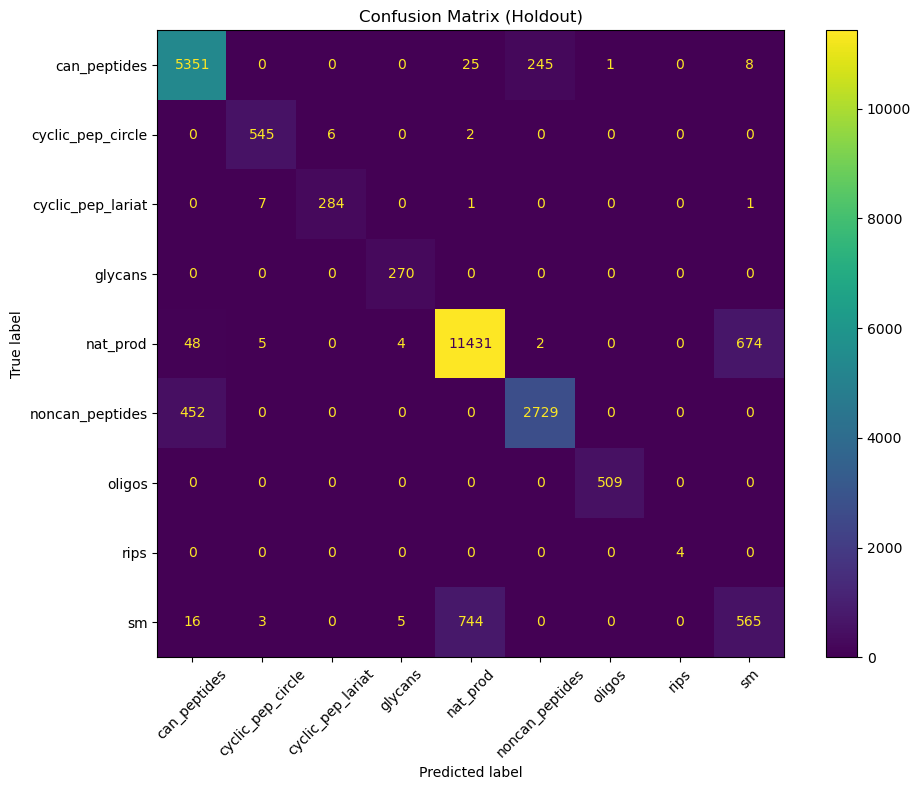

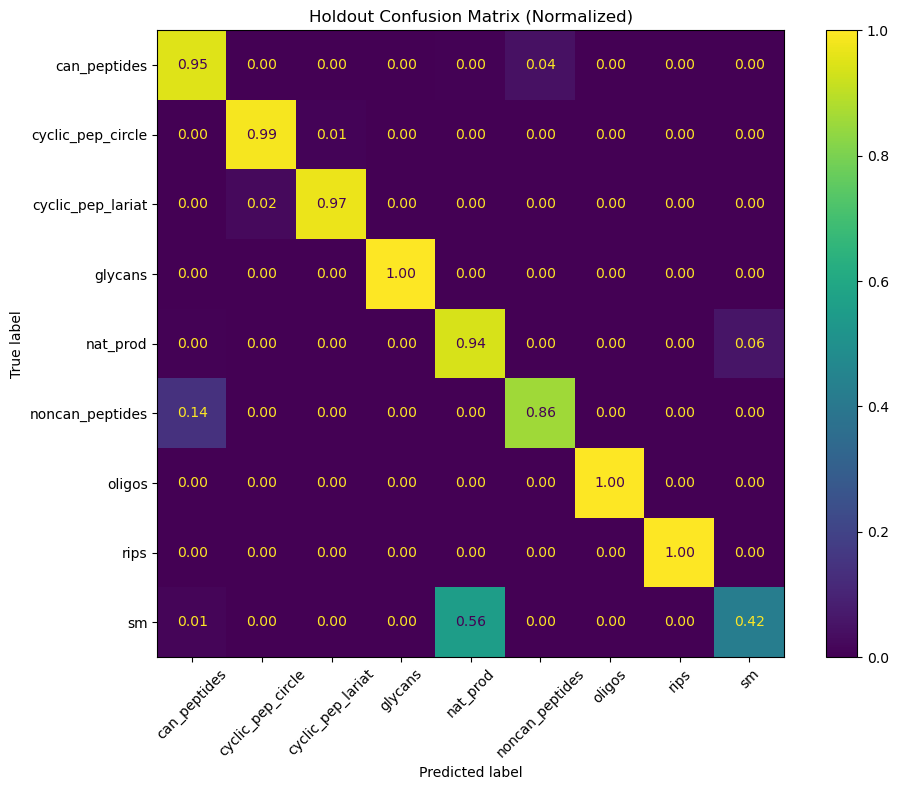

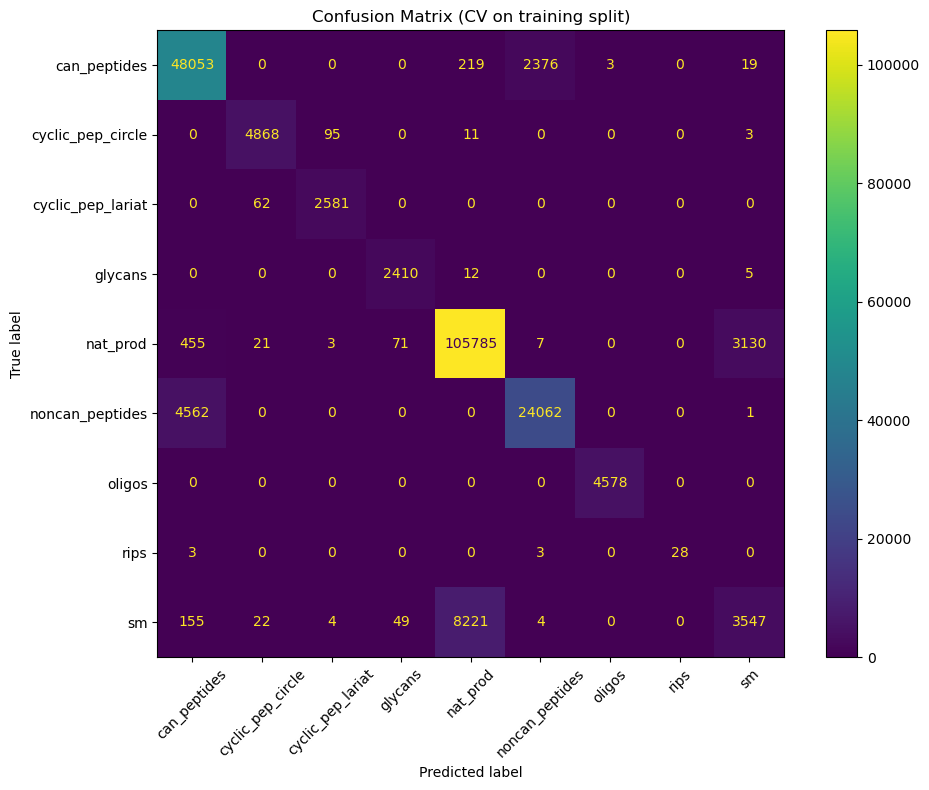

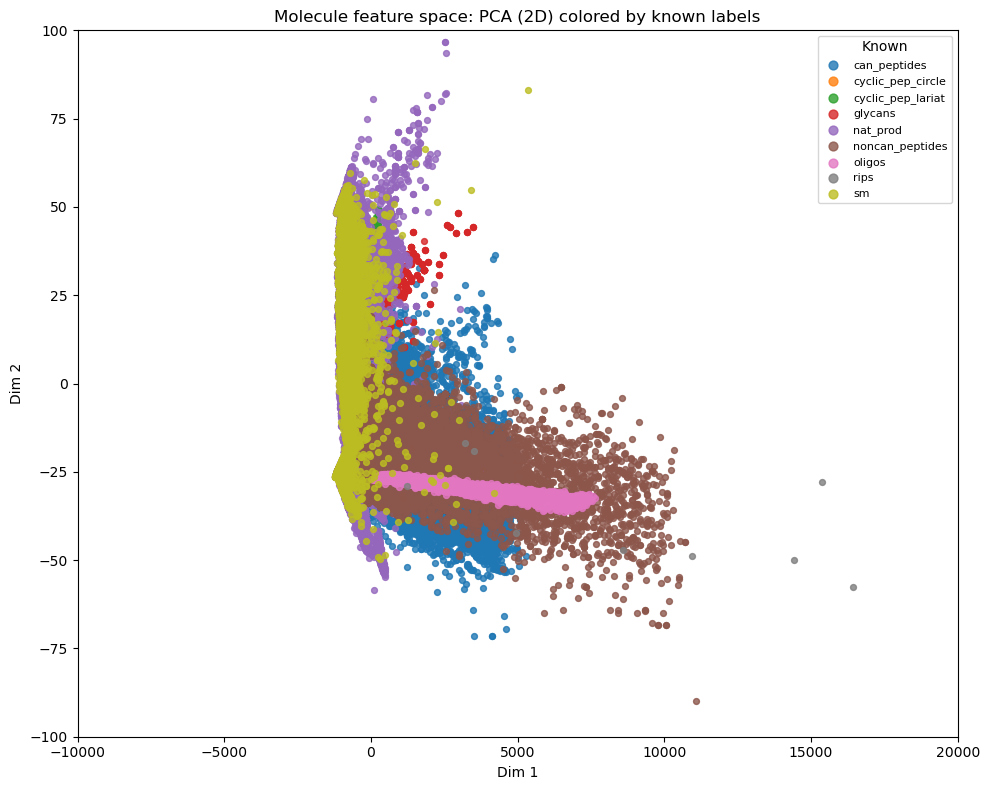

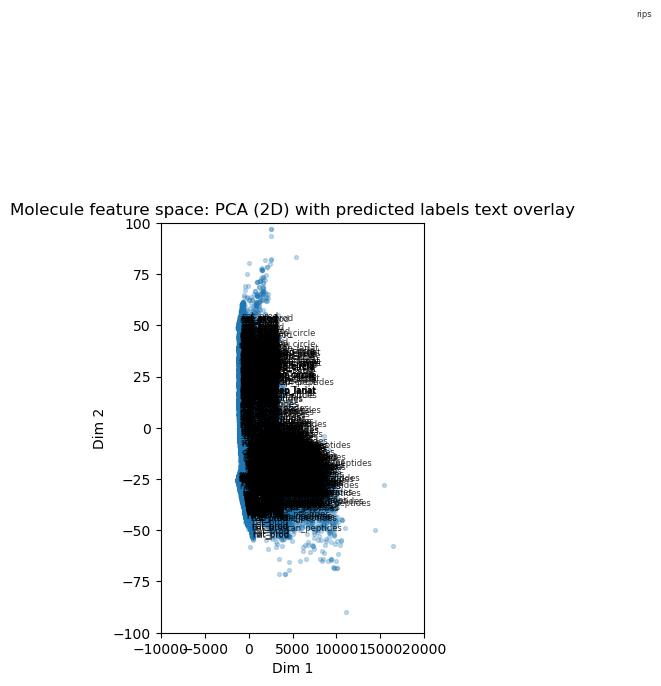

In [19]:
# Plot individual plots separately
# Confusion matrices
fig_cm_test = plot_confusion_matrix_test(results['evaluation_stats'], show_plot=True)
fig_cm_test_norm = plot_confusion_matrix_test_norm(results['evaluation_stats'], show_plot=True)
fig_cm_cv = plot_confusion_matrix_cv(results['evaluation_stats'], show_plot=True)

# Projections
data = results['data_splits']
fig_proj_known = plot_projection_known_labels(
    data['X_all'],
    data['y_all'],
    data['label_encoder'],
    method="pca",  # or "pca"
    show_plot=True,
    xlim=(-10000, 20000),
    ylim=(-100, 100),
)

if results.get('y_pred_all') is not None:
    fig_proj_pred = plot_projection_predicted_labels(
        data['X_all'],
        results['y_pred_all'],
        data['label_encoder'],
        method="pca",  # or "pca"
        show_plot=True,
        xlim=(-10000, 20000),
        ylim=(-100, 100),
    )



=== Oversampling Summary ===
Original training class distribution (90% split):
  can_peptides: 50670 molecules
  cyclic_pep_circle: 4977 molecules
  cyclic_pep_lariat: 2643 molecules
  glycans: 2427 molecules
  nat_prod: 109472 molecules
  noncan_peptides: 28625 molecules
  oligos: 4578 molecules
  rips: 34 molecules
  sm: 12002 molecules

After oversampling (balanced classes):
  can_peptides: 109472 molecules
  cyclic_pep_circle: 109472 molecules
  cyclic_pep_lariat: 109472 molecules
  glycans: 109472 molecules
  nat_prod: 109472 molecules
  noncan_peptides: 109472 molecules
  oligos: 109472 molecules
  rips: 109472 molecules
  sm: 109472 molecules

=== Holdout (10%) performance ===
Accuracy: 0.9060
                   precision    recall  f1-score   support

     can_peptides      0.912     0.950     0.931      5630
cyclic_pep_circle      0.973     0.986     0.979       553
cyclic_pep_lariat      0.979     0.969     0.974       293
          glycans      0.968     1.000     0.984    

<Figure size 640x480 with 0 Axes>

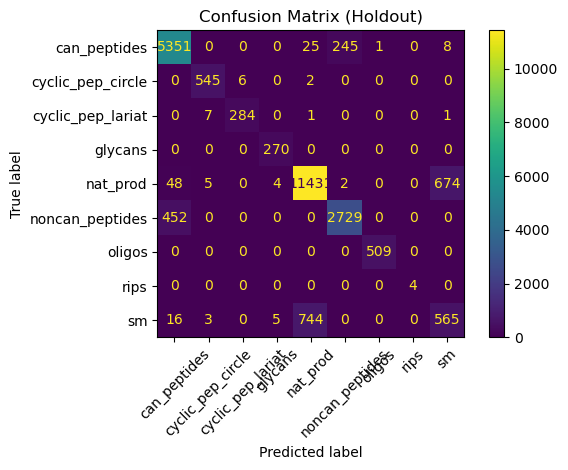

<Figure size 640x480 with 0 Axes>

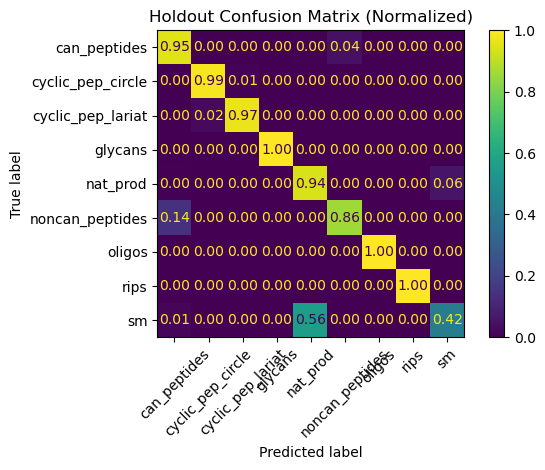


=== Cross-validated (on training split) metrics ===
Accuracy: 0.9094
                   precision    recall  f1-score   support

     can_peptides      0.903     0.948     0.925     50670
cyclic_pep_circle      0.979     0.978     0.978      4977
cyclic_pep_lariat      0.962     0.977     0.969      2643
          glycans      0.953     0.993     0.972      2427
         nat_prod      0.926     0.966     0.946    109472
  noncan_peptides      0.910     0.841     0.874     28625
           oligos      0.999     1.000     1.000      4578
             rips      1.000     0.824     0.903        34
               sm      0.529     0.296     0.379     12002

         accuracy                          0.909    215428
        macro avg      0.907     0.869     0.883    215428
     weighted avg      0.900     0.909     0.902    215428



<Figure size 640x480 with 0 Axes>

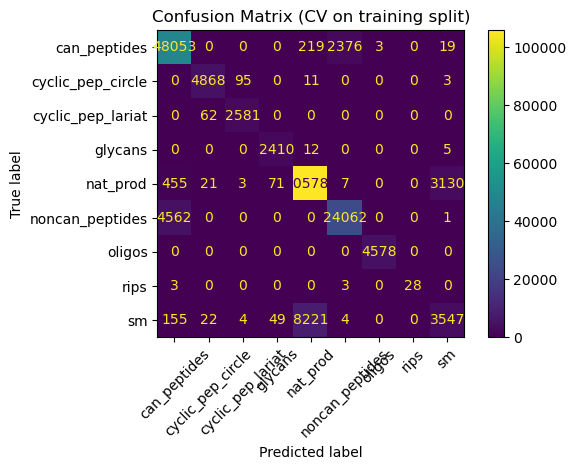


=== Holdout known vs predicted label comparison (counts) ===
            known              pred  count
         nat_prod          nat_prod  11431
     can_peptides      can_peptides   5351
  noncan_peptides   noncan_peptides   2729
               sm          nat_prod    744
         nat_prod                sm    674
               sm                sm    565
cyclic_pep_circle cyclic_pep_circle    545
           oligos            oligos    509
  noncan_peptides      can_peptides    452
cyclic_pep_lariat cyclic_pep_lariat    284
          glycans           glycans    270
     can_peptides   noncan_peptides    245
         nat_prod      can_peptides     48
     can_peptides          nat_prod     25
               sm      can_peptides     16
     can_peptides                sm      8
cyclic_pep_lariat cyclic_pep_circle      7
cyclic_pep_circle cyclic_pep_lariat      6
         nat_prod cyclic_pep_circle      5
               sm           glycans      5
             rips              rips

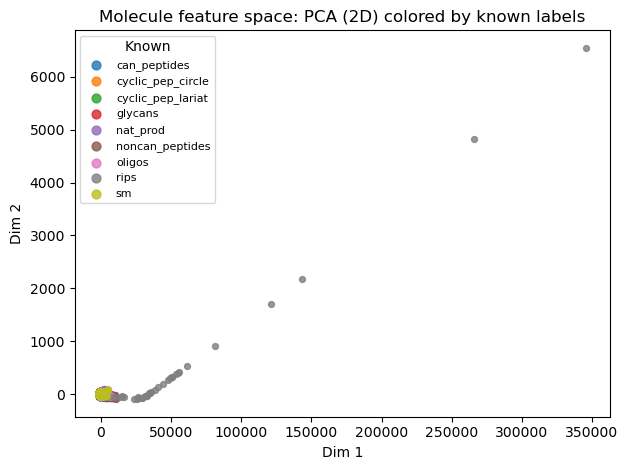

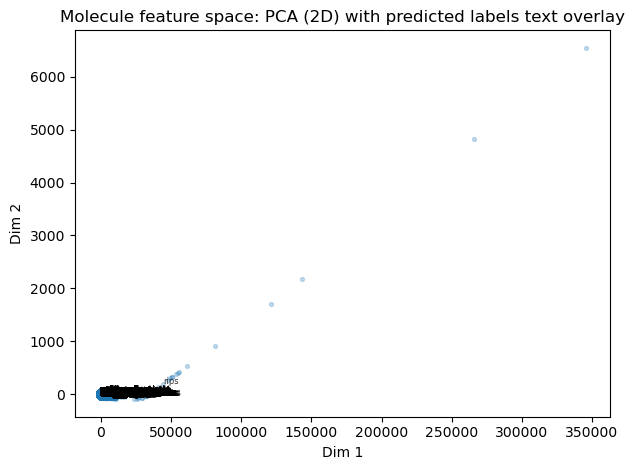

In [ ]:
#Run pipeline
#results = run_pipeline_from_matrix(
#    out_df_Pos_ctrl_featuresOnly,
#    plot_results=False,  # Don't plot during computation (default)
#)

# Plot individual plots separately -> no limits (default)
# Confusion matrices
fig_cm_test = plot_confusion_matrix_test(results['evaluation_stats'], show_plot=True)
fig_cm_test_norm = plot_confusion_matrix_test_norm(results['evaluation_stats'], show_plot=True)
fig_cm_cv = plot_confusion_matrix_cv(results['evaluation_stats'], show_plot=True)

# Projections
data = results['data_splits']
fig_proj_known = plot_projection_known_labels(
    data['X_all'],
    data['y_all'],
    data['label_encoder'],
    method="umap",  # or "pca"
    show_plot=True,
    xlim=None,  # Optional: (xmin, xmax) tuple to set x-axis limits, e.g., (-5, 5)
    ylim=None,  # Optional: (ymin, ymax) tuple to set y-axis limits, e.g., (-5, 5)
)

if results.get('y_pred_all') is not None:
    fig_proj_pred = plot_projection_predicted_labels(
        data['X_all'],
        results['y_pred_all'],
        data['label_encoder'],
        method="umap",  # or "pca"
        show_plot=True,
        xlim=None,  # Optional: (xmin, xmax) tuple to set x-axis limits, e.g., (-5, 5)
        ylim=None,  # Optional: (ymin, ymax) tuple to set y-axis limits, e.g., (-5, 5)
    )


<br><br><br><br>

# <B>  Classify ChEMBL data </B>

In [3]:
#Import featurized ChEMBL data
chunks = []
for chunk in pd.read_csv("./scratch/ChEMBL_w.originalLabels_andFeatures.csv", chunksize=50000):
    chunks.append(chunk)
chembl_features = pd.concat(chunks, ignore_index=True)
len(chembl_features)


#Read in binding infor for chembl data
#chunks = []
#for chunk in pd.read_csv("./scratch/chembl_mol_target_AC.csv", chunksize=50000):
#    chunks.append(chunk)
#chembl_BindingData = pd.concat(chunks, ignore_index=True)
#len(chembl_BindingData)






1048575

In [4]:
# Check if chembl_features is in the correct format for classification
print("=== Checking chembl_features format ===")
print(f"Total columns: {len(chembl_features.columns)}")
print(f"\nFirst 10 columns: {list(chembl_features.columns[:10])}")

# Check if it has the required "molecular_weight" column
if "molecular_weight" in chembl_features.columns:
    molecular_weight_idx = chembl_features.columns.get_loc("molecular_weight")
    feature_columns = chembl_features.columns[molecular_weight_idx:].tolist()
    print(f"\n✅ 'molecular_weight' column found at index {molecular_weight_idx}")
    print(f"✅ Number of feature columns (from molecular_weight onwards): {len(feature_columns)}")
    print(f"✅ First few features: {feature_columns[:5]}")
    print(f"\n✅ Format is CORRECT - can use columns from 'molecular_weight' onwards for classification")
else:
    print(f"\n❌ 'molecular_weight' column NOT FOUND")
    print(f"❌ Format is INCORRECT - need to match training format")
    print(f"\nTraining format: columns from 'molecular_weight' onwards")
    
chembl_features.head(3)


=== Checking chembl_features format ===
Total columns: 58

First 10 columns: ['molecule_type', 'target_id', 'target_name', 'canonical_smiles', 'feature', 'molecular_weight', 'heavy_atom_count', 'ring_count', 'largest_ring_size', 'percent_heavy_in_rings']

✅ 'molecular_weight' column found at index 5
✅ Number of feature columns (from molecular_weight onwards): 53
✅ First few features: ['molecular_weight', 'heavy_atom_count', 'ring_count', 'largest_ring_size', 'percent_heavy_in_rings']

✅ Format is CORRECT - can use columns from 'molecular_weight' onwards for classification


,molecule_type,target_id,target_name,canonical_smiles,feature,molecular_weight,heavy_atom_count,ring_count,largest_ring_size,percent_heavy_in_rings,...,pattern_GLYCOSIDIC_BOND,pattern_NUCLEOBASE_URACIL,pattern_GALACTOSE,pattern_GLUCOSE,pattern_MANNOSE,pattern_NUCLEOBASE_GUANINE,pattern_NUCLEOBASE_CYTOSINE,pattern_NUCLEOBASE_THYMINE,pattern_DEOXYRIBOSE,pattern_PURINE_BASE
0,Small molecule,133,Peroxisome proliferator-activated receptor gamma,CC(/C=C/C(F)=C(/C)c1cc(C(C)(C)C)cc(C(C)(C)C)c1...,MolecularFeatures(molecular_weight=438.5300000...,438.530,31.0,1.0,6.0,19.354839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Small molecule,133,Peroxisome proliferator-activated receptor gamma,CC(/C=C/C(F)=C(/C)c1cc(C(C)(C)C)cc(C(C)(C)C)c1...,MolecularFeatures(molecular_weight=438.5300000...,438.530,31.0,1.0,6.0,19.354839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Small molecule,10142,Melanocortin receptor 4,CCCCC(=O)N[C@@H]1CC(=O)NCCCC[C@@H](C(N)=O)NC(=...,MolecularFeatures(molecular_weight=1023.636999...,1023.637,73.0,6.0,23.0,64.383562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Create chembl_featuresOnly using the same feature columns as training (from "molecular_weight" onwards)
# This must match the training format exactly

if "molecular_weight" not in chembl_features.columns:
    raise ValueError("'molecular_weight' column not found in chembl_features. Cannot match training format.")

# Find the index of "molecular_weight" column (same as training)
molecular_weight_idx = chembl_features.columns.get_loc("molecular_weight")

# Select all columns from molecular_weight onwards (same as training)
feature_columns = chembl_features.columns[molecular_weight_idx:].tolist()
chembl_featuresOnly = chembl_features[feature_columns].copy()

print(f"Created chembl_featuresOnly with:")
print(f"  - Number of feature columns: {len(feature_columns)}")
print(f"  - Total rows: {len(chembl_featuresOnly)}")
print(f"  - First feature column: {feature_columns[0]}")
print(f"  - Last feature column: {feature_columns[-1]}")
print(f"\n✅ Format matches training data (columns from 'molecular_weight' onwards)")

chembl_featuresOnly.head(5)

In [5]:
# Load the saved model and label encoder for classification
# (This cell can be run independently after the model has been trained and saved)
model_path = "./scratch/molecular_classifier_model.joblib"
label_encoder_path = "./scratch/molecular_classifier_label_encoder.joblib"

try:
    # Try to load from saved files
    classifier = joblib.load(model_path)
    label_encoder = joblib.load(label_encoder_path)
    print(f"✅ Loaded model from: {model_path}")
    print(f"✅ Loaded label encoder from: {label_encoder_path}")
except FileNotFoundError:
    # Fall back to using results if model files don't exist
    if 'results' in globals() and 'classifier' in results:
        classifier = results['classifier']
        label_encoder = results['label_encoder']
        print("⚠️  Model files not found. Using model from 'results' variable.")
    else:
        raise FileNotFoundError(
            f"Model files not found at {model_path} and {label_encoder_path}, "
            "and 'results' variable is not available. Please train the model first."
        )


✅ Loaded model from: ./scratch/molecular_classifier_model.joblib
✅ Loaded label encoder from: ./scratch/molecular_classifier_label_encoder.joblib


### Classify ChEMBL data

In [ ]:
# Classify ChEMBL data using the trained random forest model
# chembl_featuresOnly should have the same feature columns as training (from "molecular_weight" onwards)

# Verify that chembl_featuresOnly has the expected format
if "molecular_weight" not in chembl_featuresOnly.columns:
    raise ValueError("chembl_featuresOnly must start with 'molecular_weight' column to match training format.")

# Verify it starts with molecular_weight (should be first column)
if chembl_featuresOnly.columns[0] != "molecular_weight":
    raise ValueError(f"chembl_featuresOnly must start with 'molecular_weight', but first column is '{chembl_featuresOnly.columns[0]}'")

# Use all columns from chembl_featuresOnly as features (should match training features exactly)
feature_cols = chembl_featuresOnly

# Process in chunks to avoid memory issues
chunk_size = 50000
predicted_labels_list = []

print(f"Classifying {len(chembl_featuresOnly)} rows using {len(chembl_featuresOnly.columns)} feature columns...")
print(f"  First feature: {chembl_featuresOnly.columns[0]}")
print(f"  Last feature: {chembl_featuresOnly.columns[-1]}")
print(f"  ✅ Format verified - matches training data")

for i in tqdm(range(0, len(chembl_featuresOnly), chunk_size), desc="Classifying chunks"):
    chunk_features = feature_cols.iloc[i:i+chunk_size]
    
    # Ensure numeric and handle missing values
    chunk_features_num = chunk_features.apply(pd.to_numeric, errors='coerce')
    chunk_features_num = chunk_features_num.fillna(chunk_features_num.median(numeric_only=True))
    
    # Predict labels for this chunk
    chunk_predictions_encoded = classifier.predict(chunk_features_num.values)
    
    # Decode labels back to original class names
    chunk_predictions = label_encoder.inverse_transform(chunk_predictions_encoded)
    
    predicted_labels_list.extend(chunk_predictions)

# Add predicted labels as a new column to chembl_featuresOnly
chembl_featuresOnly['predicted_label'] = predicted_labels_list

print(f"\n✅ Classification complete! Added 'predicted_label' column to chembl_featuresOnly.")
print(f"Label distribution:")
print(chembl_featuresOnly['predicted_label'].value_counts())

chembl_featuresOnly.head(5)


Classifying 1048575 rows using features from columns 5:53...


Classifying chunks:   0%|          | 0/21 [00:00<?, ?it/s]

Classifying chunks:   0%|          | 0/21 [00:00<?, ?it/s]


ValueError: X has 48 features, but RandomForestClassifier is expecting 52 features as input.

In [ ]:
# Plot individual plots separately -> no limits (default)
# Confusion matrices
fig_cm_test = plot_confusion_matrix_test(results['evaluation_stats'], show_plot=True)
fig_cm_test_norm = plot_confusion_matrix_test_norm(results['evaluation_stats'], show_plot=True)
fig_cm_cv = plot_confusion_matrix_cv(results['evaluation_stats'], show_plot=True)


In [ ]:

# Projections
data = results['data_splits']
fig_proj_known = plot_projection_known_labels(
    data['X_all'],
    data['y_all'],
    data['label_encoder'],
    method="umap",  # or "pca"
    show_plot=True,
    xlim=None,  # Optional: (xmin, xmax) tuple to set x-axis limits, e.g., (-5, 5)
    ylim=None,  # Optional: (ymin, ymax) tuple to set y-axis limits, e.g., (-5, 5)
)

if results.get('y_pred_all') is not None:
    fig_proj_pred = plot_projection_predicted_labels(
        data['X_all'],
        results['y_pred_all'],
        data['label_encoder'],
        method="umap",  # or "pca"
        show_plot=True,
        xlim=None,  # Optional: (xmin, xmax) tuple to set x-axis limits, e.g., (-5, 5)
        ylim=None,  # Optional: (ymin, ymax) tuple to set y-axis limits, e.g., (-5, 5)
    )
